In [0]:
##exploratory data analysis using Koalas and PySpark to build a regression model using the Spark distributed framework.
# used databricks env for execution , loaded file to tables and used "kdf_ccpp = ks.read_csv("/FileStore/tables/hw")"

In [0]:
#! pip install koalas
#! pip install findspark
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder.master("test[*]").getOrCreate()
# Test the spark 
df = spark.createDataFrame([{"cl": "val"} for x in range(1000)])

df.show(3, False)

+---+
cl |
+---+
val|
val|
val|
+---+
only showing top 3 rows

In [0]:
# Read the iris data
import databricks.koalas as ks
kdf_ccpp = ks.read_csv("/FileStore/tables/hw")
kdf_ccpp.head()

Out[31]:

age 
 bmi 
 elective_surgery 
 height 
 icu_id 
 pre_icu_los_days 
 readmission_status 
 weight 
 
 
 
 
 0 
 68 
 22.732803 
 0 
 180.3 
 92 
 0.541667 
 0 
 73.9 
 
 
 1 
 77 
 27.421875 
 0 
 160.0 
 90 
 0.927778 
 0 
 70.2 
 
 
 2 
 25 
 31.952749 
 0 
 172.7 
 93 
 0.000694 
 0 
 95.3 
 
 
 3 
 81 
 22.635548 
 1 
 165.1 
 92 
 0.000694 
 0 
 61.7 
 
 
 4 
 19 
 0.000000 
 0 
 188.0 
 91 
 0.073611 
 0 
 0.0

In [0]:
kdf_ccpp['weight'].plot()
kdf_ccpp['weight'].rolling(window=20).mean().plot()
kdf_ccpp['weight'].rolling(window=200).mean().plot()

Out[32]:

In [0]:
kdf_ccpp.plot()

Out[33]:

In [0]:
kdf_ccpp.rolling(window=20).mean().plot()

Out[34]:

In [0]:
kdf_ccpp.describe()

Out[35]:

age 
 bmi 
 elective_surgery 
 height 
 icu_id 
 pre_icu_los_days 
 readmission_status 
 weight 
 
 
 
 
 count 
 130157.000000 
 130157.000000 
 130157.000000 
 130157.000000 
 130157.000000 
 130157.000000 
 130157.0 
 130157.000000 
 
 
 mean 
 59.619268 
 28.106049 
 0.189840 
 166.900686 
 662.428344 
 0.839933 
 0.0 
 81.561731 
 
 
 std 
 20.342323 
 9.702723 
 0.392176 
 23.816143 
 304.259843 
 2.485337 
 0.0 
 28.078595 
 
 
 min 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 82.000000 
 -0.250000 
 0.0 
 0.000000 
 
 
 25% 
 50.000000 
 23.112472 
 0.000000 
 162.000000 
 427.000000 
 0.045833 
 0.0 
 65.300000 
 
 
 50% 
 63.000000 
 27.335640 
 0.000000 
 170.000000 
 653.000000 
 0.155556 
 0.0 
 79.400000 
 
 
 75% 
 74.000000 
 32.543618 
 0.000000 
 177.800000 
 969.000000 
 0.423611 
 0.0 
 96.100000 
 
 
 max 
 89.000000 
 67.814990 
 1.000000 
 195.590000 
 1111.000000 
 175.627778 
 0.0 
 186.000000

Out[36]:

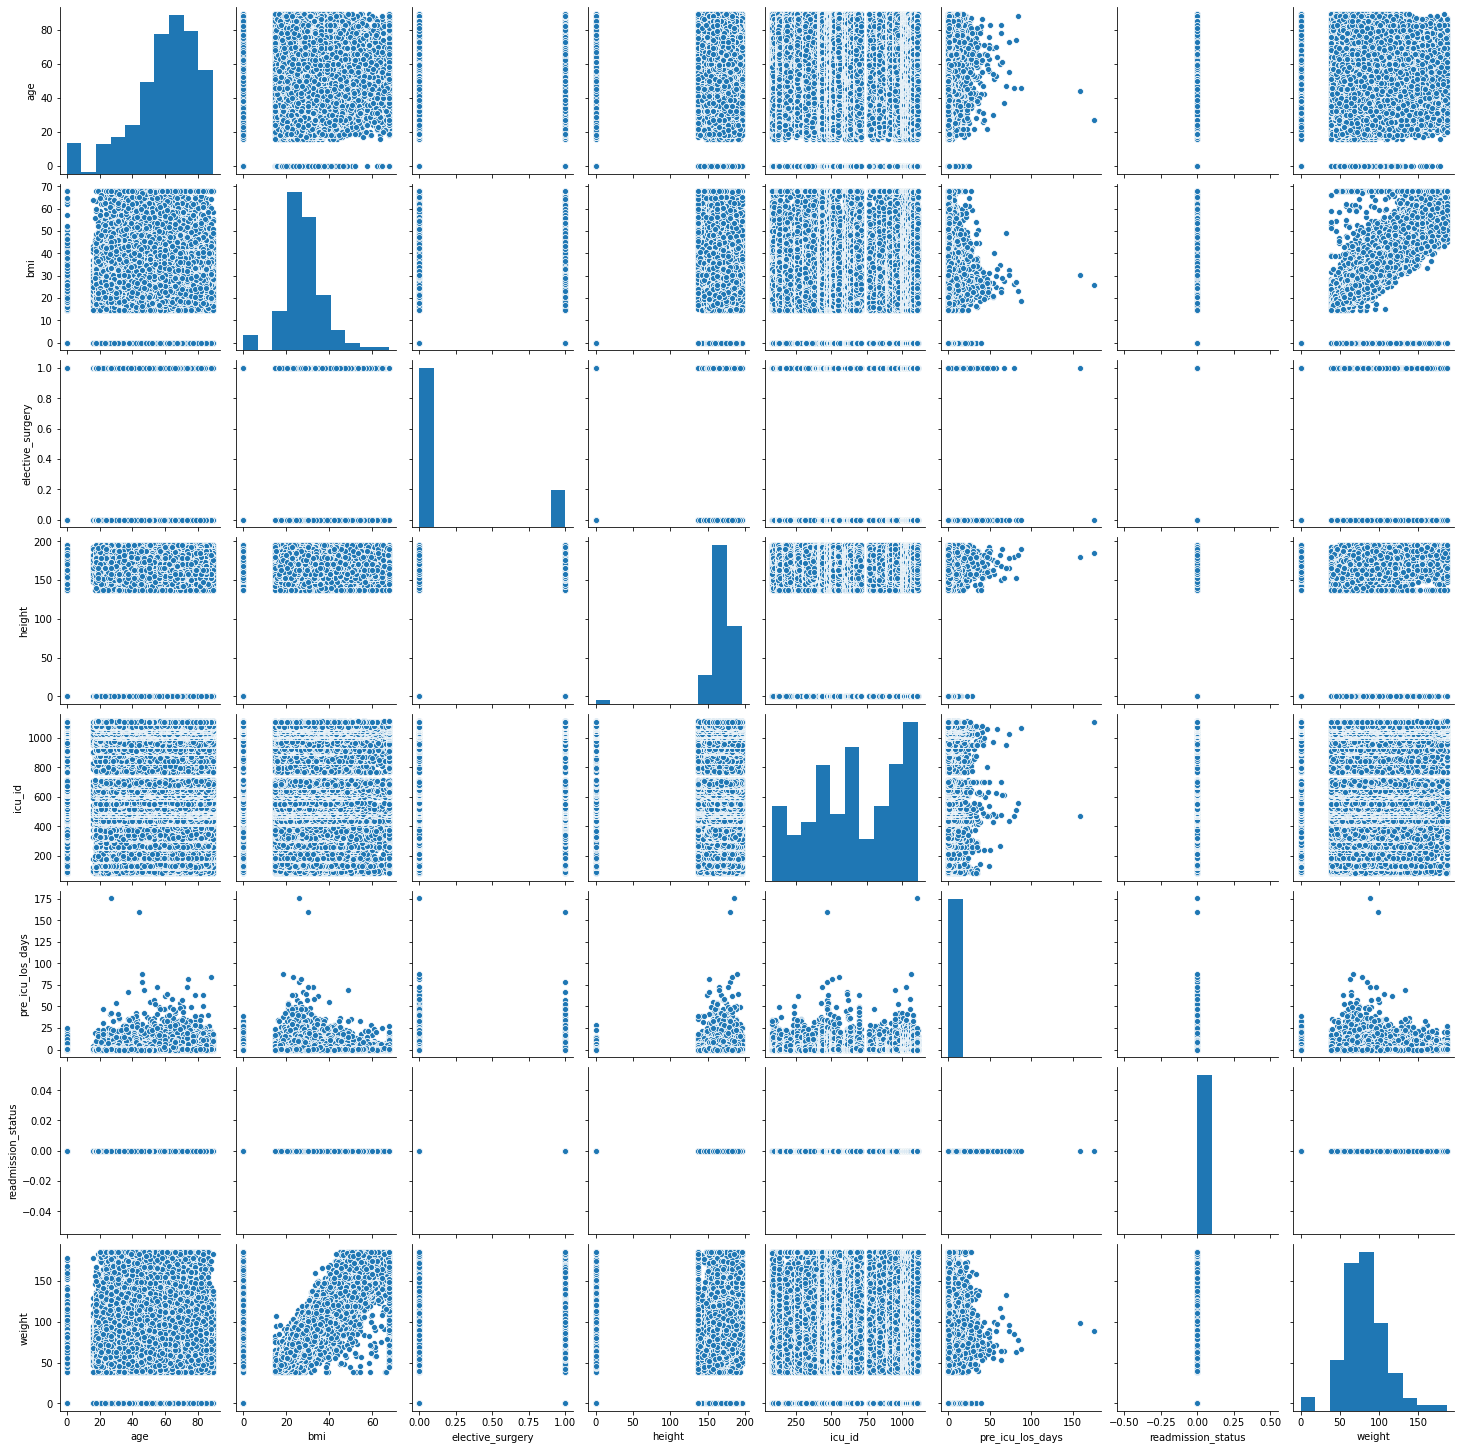

<seaborn.axisgrid.PairGrid at 0x7fc589961460>

In [0]:
import seaborn as sns
sns.pairplot(kdf_ccpp.to_pandas())

In [0]:
# Create the moving average features
kdf = kdf_ccpp.rolling(window=20, min_periods=1).mean()
# Convert the Koalas DataFrame into Spark DataFrame
sdf = kdf.to_spark()
sdf.show(5,False)

+------------------+------------------+----------------+-------+-----------------+-------------------+------------------+------------------+
age |bmi |elective_surgery|height |icu_id |pre_icu_los_days |readmission_status|weight |
+------------------+------------------+----------------+-------+-----------------+-------------------+------------------+------------------+
68.0 |22.73280282 |0.0 |180.3 |92.0 |0.541666667 |0.0 |73.9 |
72.5 |25.07733891 |0.0 |170.15 |91.0 |0.7347222225000001 |0.0 |72.05000000000001 |
56.666666666666664|27.369142213333333|0.0 |171.0 |91.66666666666667|0.4900462963333334 |0.0 |79.80000000000001 |
62.75 |26.1857437175 |0.25 |169.525|91.75 |0.3677083332500001 |0.0 |75.275 |
54.0 |20.948594974 |0.2 |173.22 |91.6 |0.30888888880000004|0.0 |60.220000000000006|
+------------------+------------------+----------------+-------+-----------------+-------------------+------------------+------------------+
only showing top 5 rows

In [0]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import GBTRegressor


In [0]:
# Create the feature column using VectorAssembler class
vectorAssembler = VectorAssembler(inputCols =["age","bmi","elective_surgery","height","icu_id","pre_icu_los_days","readmission_status"], outputCol = "features")
vpp_sdf = vectorAssembler.transform(sdf)
vpp_sdf.show(2, False)

+----+-----------+----------------+------+------+------------------+------------------+-----------------+---------------------------------------------------------+
age |bmi |elective_surgery|height|icu_id|pre_icu_los_days |readmission_status|weight |features |
+----+-----------+----------------+------+------+------------------+------------------+-----------------+---------------------------------------------------------+
68.0|22.73280282|0.0 |180.3 |92.0 |0.541666667 |0.0 |73.9 |[68.0,22.73280282,0.0,180.3,92.0,0.541666667,0.0] |
72.5|25.07733891|0.0 |170.15|91.0 |0.7347222225000001|0.0 |72.05000000000001|[72.5,25.07733891,0.0,170.15,91.0,0.7347222225000001,0.0]|
+----+-----------+----------------+------+------+------------------+------------------+-----------------+---------------------------------------------------------+
only showing top 2 rows

In [0]:
# Define train and test data split
splits = vpp_sdf.randomSplit([0.7,0.3])
train_df = splits[0]
test_df = splits[1]

In [0]:
# Define the GBT Model
gbt = GBTRegressor(featuresCol="features", labelCol="weight")
gbt_model = gbt.fit(train_df)
gbt_predictions = gbt_model.transform(test_df)

In [0]:
# Evaluate the GBT Model
gbt_evaluator = RegressionEvaluator(labelCol="weight", predictionCol="prediction", metricName="rmse")
gbt_rmse = gbt_evaluator.evaluate(gbt_predictions)
print("The RMSE of GBT Tree regression Model is {}".format(gbt_rmse))

The RMSE of GBT Tree regression Model is 2.636214337738753

In [0]:
kdf_predictions = ks.DataFrame(gbt_predictions)
kdf_predictions.head()

Out[43]: /databricks/spark/python/pyspark/sql/pandas/conversion.py:92: UserWarning:

toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
 Unable to convert the field features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.

age 
 bmi 
 elective_surgery 
 height 
 icu_id 
 pre_icu_los_days 
 readmission_status 
 weight 
 features 
 prediction 
 
 
 
 
 0 
 37.85 
 26.645779 
 0.25 
 168.5250 
 1034.50 
 1.474549 
 0.0 
 76.200 
 [37.85, 26.645779005499996, 0.25, 168.52500000... 
 76.624310 
 
 
 1 
 38.45 
 26.371188 
 0.25 
 167.1300 
 1034.75 
 1.423611 
 0.0 
 74.130 
 [38.45, 26.371187636500004, 0.25, 167.13000000... 
 75.251045 
 
 
 2 
 39.40 
 25.670862 
 0.05 
 170.8415 
 1034.55 
 0.349306 
 0.0 
 74.090 
 [39.4, 25.670862284499997, 0.05, 170.8415, 103... 
 75.568574 
 
 
 3 
 39.50 
 20.580242 
 0.10 
 159.0900 
 98.80 
 0.067743 
 0.0 
 57.635 
 [39.5, 20.58024197, 0.1, 159.08999999999997, 9... 
 57.778499 
 
 
 4 
 40.30 
 30.578522 
 0.30 
 161.5400 
 809.15 
 0.778889 
 0.0 
 91.917 
 [40.3, 30.578522292500004, 0.3, 161.5400000000... 
 88.687635

In [0]:
kdf_predictions[['weight', 'prediction']].plot()

Out[44]: